In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import folium
import json
from scipy.stats import pearsonr

In [2]:
file_path = "C:/Users/vehico/Documents/Thesis/Distance-project/DATA_DISTANCIAS/AGRUPADOS/EDUCACION/nucleos/aggregated_school_distances_transit_ROMA.csv"

df = pd.read_csv(file_path)


df.rename(columns={
    'Comune': 'Municipality',
    'Nucleo_ID': 'UrbanCentre_ID',
    'Popolazione': 'Population',
    'SI_mean_km': 'Kindergarten_mean_km',
    'SI_St.Dv_km': 'Kindergarten_std_km',
    'SI_mean_min': 'Kindergarten_mean_min',
    'SI_St.Dv_min': 'Kindergarten_std_min',
    'SP_mean_km': 'Primary_mean_km',
    'SP_St.Dv_km': 'Primary_std_km',
    'SP_mean_min': 'Primary_mean_min',
    'SP_St.Dv_min': 'Primary_std_min',
    'SS_mean_km': 'Secondary_mean_km',
    'SS_St.Dv_km': 'Secondary_std_km',
    'SS_mean_min': 'Secondary_mean_min',
    'SS_St.Dv_min': 'Secondary_std_min'
}, inplace=True)

In [3]:
# Melt distance columns
df_distance_long = df.melt(
    id_vars=['Municipality', 'UrbanCentre_ID'],
    value_vars=['Kindergarten_mean_km', 'Primary_mean_km', 'Secondary_mean_km'],
    var_name='School_Level',
    value_name='Distance_km'
)

# Melt time columns
df_time_long = df.melt(
    id_vars=['Municipality', 'UrbanCentre_ID'],
    value_vars=['Kindergarten_mean_min', 'Primary_mean_min', 'Secondary_mean_min'],
    var_name='School_Level',
    value_name='Time_min'
)

# Harmonize school level labels
df_distance_long['School_Level'] = df_distance_long['School_Level'].str.replace('_mean_km', '')
df_time_long['School_Level'] = df_time_long['School_Level'].str.replace('_mean_min', '')

# Merge distances and times
df_long = pd.merge(
    df_distance_long,
    df_time_long,
    on=['Municipality', 'UrbanCentre_ID', 'School_Level']
)

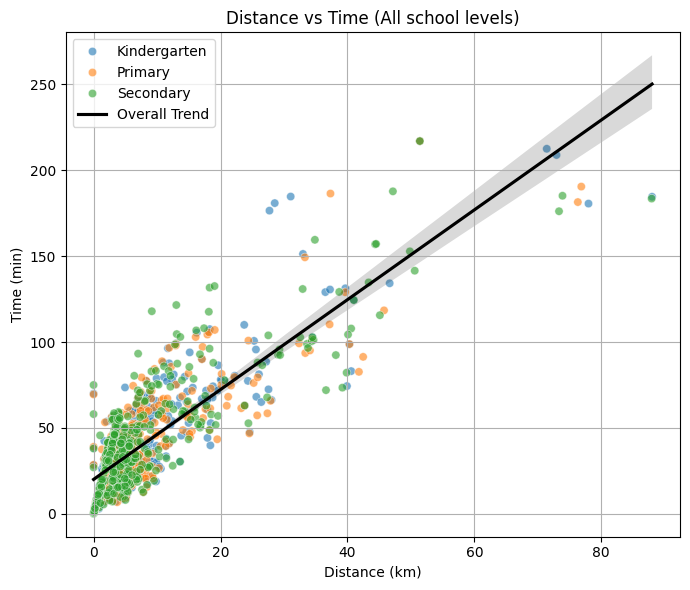

In [4]:
plt.figure(figsize=(7, 6))
sns.scatterplot(data=df_long, x='Distance_km', y='Time_min', hue='School_Level', alpha=0.6)
sns.regplot(data=df_long, x='Distance_km', y='Time_min', scatter=False, color='black', label='Overall Trend')
plt.title("Distance vs Time (All school levels)")
plt.xlabel("Distance (km)")
plt.ylabel("Time (min)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# Drop rows with NaN in either column
df_corr = df_long[['Distance_km', 'Time_min']].dropna()

# Now compute Pearson correlation
r_all, pval_all = pearsonr(df_corr['Distance_km'], df_corr['Time_min'])
print(f"🔗 Overall Pearson correlation: r = {r_all:.3f} (p-value = {pval_all:.3e})")

🔗 Overall Pearson correlation: r = 0.834 (p-value = 0.000e+00)


## Healthcare

In [14]:
file_path_medici = "C:/Users/vehico/Documents/Thesis/Distance-project/DATA_DISTANCIAS/AGRUPADOS/SANIDAD/nucleos/aggregated_medici_distances_transit_ROMA.csv"
df_medici = pd.read_csv(file_path_medici)

df_medici.rename(columns={
    'Comune': 'Municipality',
    'Nucleo_ID': 'UrbanCentre_ID',
    'Popolazione': 'Population',
    'mean_km' : 'Family_Doctors_mean_km',
    'mean_min' : 'Family_Doctors_mean_min',
    'St.Dv_km' : 'Family_Doctors_St.Dv_km',
    'St.Dv_min' : 'Family_Doctors_St.Dv_min',
}, inplace=True)

df_medici.columns.tolist()

['Municipality',
 'UrbanCentre_ID',
 'Population',
 'Family_Doctors_mean_km',
 'Family_Doctors_St.Dv_km',
 'Family_Doctors_mean_min',
 'Family_Doctors_St.Dv_min',
 'match_ratio']

In [15]:
file_path_hospitals = "C:/Users/vehico\Documents/Thesis/Distance-project/DATA_DISTANCIAS/AGRUPADOS/SANIDAD/nucleos/aggregated_hospital_distances_transit_ROMA.csv"

df_hospitals = pd.read_csv(file_path_hospitals)

df_hospitals.rename(columns={
    'Comune': 'Municipality',
    'Nucleo_ID': 'UrbanCentre_ID',
    'Popolazione': 'Population',
    'mean_km' : 'Hospitals_mean_km',
    'mean_min' : 'Hospitals_mean_min',
    'St.Dv_km' : 'Hospitals_St.Dv_km',
    'St.Dv_min' : 'Hospitals_St.Dv_min',
}, inplace=True)

df_hospitals.columns.tolist()

['Municipality',
 'UrbanCentre_ID',
 'Population',
 'Hospitals_mean_km',
 'Hospitals_St.Dv_km',
 'Hospitals_mean_min',
 'Hospitals_St.Dv_min',
 'match_ratio']

In [16]:
# Pulizia medici di famiglia
df_medici_clean = df_medici.copy()
df_medici_clean['Health_Service'] = 'Family_Doctors'
df_medici_clean.rename(columns={
    'Family_Doctors_mean_km': 'Distance_km',
    'Family_Doctors_mean_min': 'Time_min'
}, inplace=True)
df_medici_clean = df_medici_clean[['Municipality', 'UrbanCentre_ID', 'Population', 'Distance_km', 'Time_min', 'Health_Service']]

# Pulizia ospedali
df_hospitals_clean = df_hospitals.copy()
df_hospitals_clean['Health_Service'] = 'Hospitals'
df_hospitals_clean.rename(columns={
    'Hospitals_mean_km': 'Distance_km',
    'Hospitals_mean_min': 'Time_min'
}, inplace=True)
df_hospitals_clean = df_hospitals_clean[['Municipality', 'UrbanCentre_ID', 'Population', 'Distance_km', 'Time_min', 'Health_Service']]

# Unione dei due dataset
df_health_long = pd.concat([df_medici_clean, df_hospitals_clean], ignore_index=True)


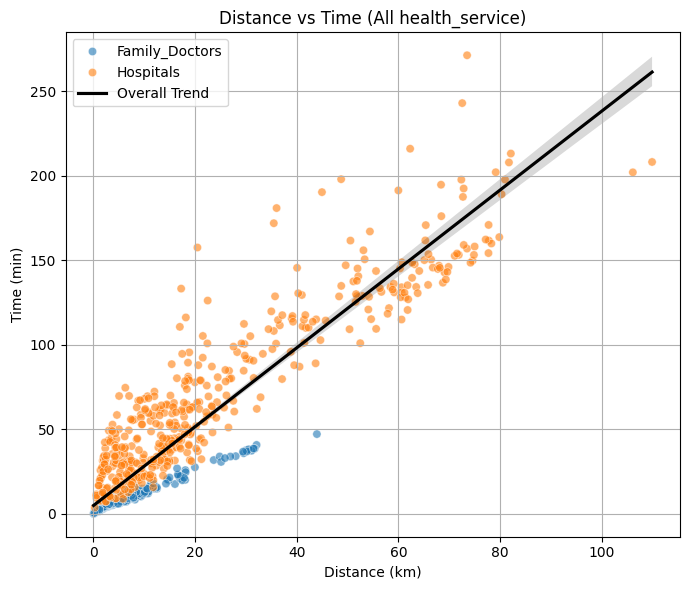

In [17]:
plt.figure(figsize=(7, 6))
sns.scatterplot(data=df_health_long, x='Distance_km', y='Time_min', hue='Health_Service', alpha=0.6)
sns.regplot(data=df_health_long, x='Distance_km', y='Time_min', scatter=False, color='black', label='Overall Trend')
plt.title("Distance vs Time (All health_service)")
plt.xlabel("Distance (km)")
plt.ylabel("Time (min)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
df_corr = df_health_long[['Distance_km', 'Time_min']].dropna()
r_all, pval_all = pearsonr(df_corr['Distance_km'], df_corr['Time_min'])
print(f"🔗 Overall Pearson correlation: r = {r_all:.3f} (p-value = {pval_all:.3e})")

🔗 Overall Pearson correlation: r = 0.927 (p-value = 0.000e+00)


In [12]:
# Drop missing
df_clean = df_health_long[['Distance_km', 'Time_min']].dropna()

# Fit linear model
X = df_clean[['Distance_km']]
y = df_clean['Time_min']
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# Add residuals to the DataFrame
df_clean['Residual'] = y - y_pred
df_clean['AbsResidual'] = np.abs(df_clean['Residual'])

In [13]:
# Filtra solo righe valide (senza NaN)
df_clean = df_health_long.dropna(subset=['Distance_km', 'Time_min'])

# Fit linear regression
X = df_clean[['Distance_km']]
y = df_clean['Time_min']
model = LinearRegression().fit(X, y)
y_pred = model.predict(X)

# Aggiungi residui al dataframe originale (non ridotto!)
df_clean['Residual'] = y - y_pred
df_clean['AbsResidual'] = np.abs(df_clean['Residual'])

# Trova i top 10 outlier (maggior tempo rispetto a quanto previsto dalla distanza)
top_outliers = df_clean.sort_values(by='AbsResidual', ascending=False).head(10)

# Mostra le colonne chiave
print("🚨 Top 10 outliers (unexpected high/low travel time):")
print(top_outliers[['Municipality', 'UrbanCentre_ID', 'Health_Service', 'Distance_km', 'Time_min', 'Residual']])

🚨 Top 10 outliers (unexpected high/low travel time):
             Municipality  UrbanCentre_ID  Health_Service  Distance_km  \
392       SAN VITO ROMANO      5810010001  Family_Doctors   333.522333   
590             CERVETERI      5802920011       Hospitals    73.504000   
488    ANGUILLARA SABAZIA      5800520005       Hospitals    20.462000   
541  CAPRANICA PRENESTINA      5801920002       Hospitals    36.032000   
599             CERVETERI      5802926609       Hospitals    48.731000   
540  CAPRANICA PRENESTINA      5801910002       Hospitals    44.957000   
539  CAPRANICA PRENESTINA      5801910001       Hospitals    35.485000   
596             CERVETERI      5802926622       Hospitals    72.544000   
754            PALESTRINA      5807410001       Hospitals    17.262000   
822             SACROFANO      5809320007       Hospitals    62.302000   

       Time_min    Residual  
392  222.927778 -433.285929  
590  271.166667  118.391088  
488  157.516667  107.439097  
541  180.833

C:\Users\vehico\AppData\Local\Temp\ipykernel_20208\4058586070.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Residual'] = y - y_pred
C:\Users\vehico\AppData\Local\Temp\ipykernel_20208\4058586070.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['AbsResidual'] = np.abs(df_clean['Residual'])
